# Trap Optimization

#### We have a desired intensity field. We are seeking a phase such that the intensity field has desired characteristics. For this purpose, implement a direct search algorithm (DSA), where we 
#### - choose a trial phase field
#### - pick random pixel 
#### - change value of that pixel, and get a new intensity $I_m$
#### - generate metric, and decide whether to accept or reject change
#### - Iterate

## Begin with desired intensity hologram
#### $M$ bright spots, each bright spot at location $r_{m}$
#### Say the field is a DoG
$u(\xi,\eta,z) = \frac{-u_{0}\, i\pi}{\lambda z}e^{ikz + \frac{i\pi}{\lambda z}(\xi^2 + \eta^2)} \times [\frac{1}{a}e^{-\frac{\pi^2}{\lambda^2 z^2 a}(\xi^2+\eta^2)} - \frac{1}{b}e^{-\frac{\pi^2}{\lambda^2 z^2 b}(\xi^2+\eta^2)}]$, where $a = (\frac{1}{\Sigma^2}-\frac{i\pi}{\lambda z})$ and $b = (\frac{1}{\sigma^2}-\frac{i\pi}{\lambda z})$

In [331]:
import numpy as np
from scipy import special as sp
from scipy import constants as sc
from matplotlib import pyplot as plt

#define relevant quantities
P = 1 #power ~ 1 Watt
pi = sc.pi
e_0 = sc.epsilon_0 #vacuum permittivity
wavelength = 1064*10**-9 
k = 2*pi/wavelength
w_0 = 1*10**-6 #beam waist
z_R = pi*w_0**2/wavelength #Rayleigh range (~2.9 um)
f = 2*10**-6 #choose some other value that may be more accurate
u_0 = np.sqrt(P/(pi*(w_0**2*(1+(f/z_R)**2)))) #intensity is proportional to u_0^2. And u_0^2 is power/area

def get_int_d_DoG():
    #first step is to have an array for the hologram. This is the intensity, discretized. So, basically, this would be
    #I_m(D)
    z = f
    kappa = 1j*pi/(wavelength*z) #quantity to simplify calculations
    Sigma, sigma  = 10*f, 5*f #Sigma (larger value) and sigma define our fat and narrow gaussians resp.
    a, b = (1/Sigma**2 - kappa), (1/sigma**2 - kappa)
    xmax, dx = 10e-5, 10e-7
    xlist = np.linspace(-xmax, xmax, int(xmax/dx))
    ylist = np.linspace(-xmax, xmax, int(xmax/dx))
    u_d_DoG = np.zeros([len(range(int(xmax/dx))),len(range(int(xmax/dx)))], dtype="complex_") #desired field
    int_d_DoG = np.zeros([len(range(int(xmax/dx))),len(range(int(xmax/dx)))]) #desired intensity of the hologram, DoG
    #my_hist = [] #a histogram to map out distributions of intensity values @ hologram
    for xi in range(len(xlist)):
        for yi in range(len(ylist)):
            #xi and yi will denote the pixel
            x, y = xlist[xi], ylist[yi]
            u1 = -kappa*u_0 *  np.exp(1j*k*z + kappa*(x**2+y**2))
            u2 = np.exp(-pi**2 * (x**2+y**2) /(wavelength**2*z**2*a))
            u = -kappa*u_0 *  np.exp(1j*k*z + kappa*(x**2+y**2)) * \
            ((1/a) * np.exp(-pi**2 * (x**2+y**2) /(wavelength**2*z**2*a)) - \
            (1/b) * np.exp(-pi**2 * (x**2+y**2) /(wavelength**2*z**2*b)))
            u_d_DoG[xi][yi] = u
            int_d_DoG[xi][yi] = np.imag(u)**2 + np.real(u)**2
            #my_hist.append(np.log10(np.imag(u)**2 + np.real(u)**2))
    #plt.figure(0)
    #plt.imshow(int_d_DoG, cmap = 'gray', interpolation = 'nearest')
    #plt.colorbar()
    ###distribution of intensities
    #plt.figure(1)
    #a = np.hstack(my_hist)
    #plt.hist(a, density=False, bins='auto') 
    #plt.ylabel('counts')
    #plt.xlabel('$\mathrm{log}_{10}$ intensity')
    #plt.show()
    return u_d_DoG
    #second step is to have a trial phase function. e.g. phi = l*theta, or phi = k*rho^2*z/(2*f^2)
    #third step is to change a pixel of this phase randomly -> observe corresponding new intensity I_m
    #if improved, accept. Else, reject.

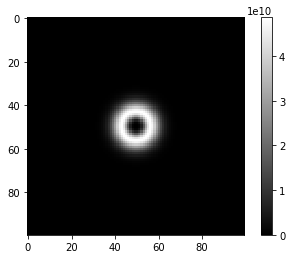

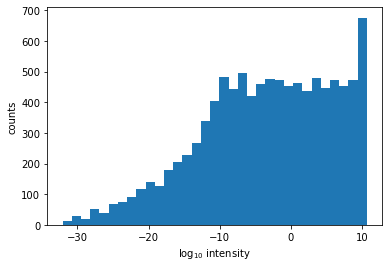

array([[8.11938541e-33, 5.99820090e-32, 4.25396990e-31, ...,
        4.25396990e-31, 5.99820090e-32, 8.11938541e-33],
       [5.99820090e-32, 4.43117456e-31, 3.14262285e-30, ...,
        3.14262285e-30, 4.43117456e-31, 5.99820090e-32],
       [4.25396990e-31, 3.14262285e-30, 2.22877213e-29, ...,
        2.22877213e-29, 3.14262285e-30, 4.25396990e-31],
       ...,
       [4.25396990e-31, 3.14262285e-30, 2.22877213e-29, ...,
        2.22877213e-29, 3.14262285e-30, 4.25396990e-31],
       [5.99820090e-32, 4.43117456e-31, 3.14262285e-30, ...,
        3.14262285e-30, 4.43117456e-31, 5.99820090e-32],
       [8.11938541e-33, 5.99820090e-32, 4.25396990e-31, ...,
        4.25396990e-31, 5.99820090e-32, 8.11938541e-33]])

In [140]:
get_int_d_DoG()

#### Notes:
#### One of the degrees of freedom is the DoG shape, defined by $\Sigma$ and $\sigma$, and we can choose what suits our fancy. They ought to be ~$f$. 

In [342]:
def phase():
    #just a way to visualize different phases
    xmax, dx = 10e-5, 10e-7
    xlist = np.linspace(-xmax, xmax, int(xmax/dx))
    ylist = np.linspace(-xmax, xmax, int(xmax/dx))
    #one possibility is m*phi
    m = 1
    phi1 = np.zeros([len(range(int(xmax/dx))),len(range(int(xmax/dx)))]) #desired intensity of the hologram, DoG
    #another possibility is k*r^2*z/(2*f^2)
    phi2 = np.zeros([len(range(int(xmax/dx))),len(range(int(xmax/dx)))]) #desired intensity of the hologram, DoG
    for xi in range(len(xlist)):
        for yi in range(len(ylist)):
        #xi and yi will denote the pixel
            x, y = xlist[xi], ylist[yi]
            if x!=0:
                phi1[xi][yi] = 2*(m*np.arctan(y/x))+pi #make it span [0,2*pi]
            else:
                phi1[xi][yi] = 2*(m*pi/2)+pi
            phi2[xi][yi] = k*(x**2+y**2)/(2*f) #z=f
    #plt.figure(0)
    #plt.title('$m\phi$')
    #plt.imshow(phi1, cmap = 'gray', interpolation = 'nearest')
    #plt.colorbar()
    #plt.figure(1)
    #plt.title('$kzr^2/2f^2$')
    #plt.imshow(phi2, cmap = 'gray', interpolation = 'nearest')
    #plt.colorbar()
    #K = np.exp(1j*phi1) #phase matrix 
    return phi1

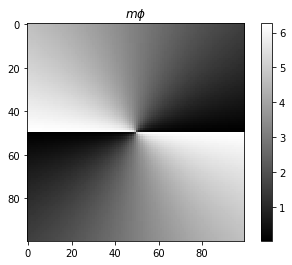

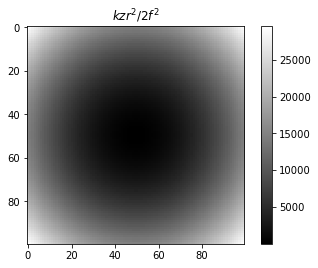

In [291]:
phase()

In [489]:
import random

#first, we need a function that takes an array of phase, and returns value of pixels. And we need another function 
    #that does the reverse.
def pixelate(Phi):
    #Phi goes from 0->2*pi
    Phi_discrete = Phi.copy()
    for row in range(len(Phi)):
        for col in range(len(Phi)):
            Phi_discrete[row][col] = int(Phi[row][col]/(2*pi) * 256) #[0,255]
    return Phi_discrete

def unpixelate(Phi_discrete):
    #Phi_discrete goes from 0->255
    Phi = Phi_discrete.copy()
    for row in range(len(Phi_discrete)):
        for col in range(len(Phi_discrete)):
            Phi[row][col] = int(Phi_discrete[row][col]*(2*pi) / 256) #[0,2*pi]
    return Phi

def transf_function(rho_j, phi_j): #rho_j and phi_j
    #for every pixel in the DOE, there exists a transfer function
    xmax, dx = 10e-5, 10e-7
    xlist = np.linspace(-xmax, xmax, int(xmax/dx))
    ylist = np.linspace(-xmax, xmax, int(xmax/dx))    
    T = np.zeros([len(range(int(xmax/dx))),len(range(int(xmax/dx)))], dtype="complex_")
    for x_index in range(len(T)):
        for y_index in range(len(T)):
            x = xlist[x_index]
            y = ylist[y_index]
            r = np.sqrt(x**2 + y**2)
            if x!= 0:
                theta = np.arctan(y/x)
            else:
                theta = pi/2
            arg = -1j*k/f * (r*rho_j*np.cos(phi_j-theta))
            T[x_index][y_index] = np.exp(arg)
    return T
            
def metropolis(trial_phase):
    #trial phase is obtained from elsewhere. We first pixelate it
    mylen = len(trial_phase)
    Phi_discrete = pixelate(trial_phase)
    Phi_discrete_upd = Phi_discrete.copy() #make a copy
    #get a random location, a random value, and the current value
    random_loc = [random.randrange(0,mylen), random.randrange(0,mylen)]
    random_px = random.randrange(0,255)  
    current_px = Phi_discrete[random.randrange(0,mylen)][random.randrange(0,mylen)]
    #for these random values, we need to compute phi_j, delta_phi_j, so the corresponding change in the field
        #may be found. rho_j, as well
    phi_j, delta_phi_j = random_px*2*pi/256, (random_px-current_px)*2*pi/256
    xmax, dx = 10e-4, 10e-6
    rho_j = np.sqrt((-xmax+(random_loc[0]*dx/mylen))**2 + (-xmax+(random_loc[0]*dx/mylen))**2)
    #now, let's see how it affects the field
    K = np.exp(1j*trial_phase)
    K_inv = np.conj(K)
    #get the T matrix
    T = transf_function(rho_j,phi_j)
    #we need to compute the change in field at every point. Iterate over the DOE plane. 
    u = get_int_d_DoG()
    delta_E = K_inv * T * np.exp(1j*phi_j) * (np.exp(1j*delta_phi_j)-1) * u
    #add this to the existing field
    E = K_inv * T * np.exp(1j*(current_px*2*pi/256)) * u
    E_new = E + delta_E
    I_d = np.real(u)**2 + np.imag(u)**2
    ave_I_d = np.average(I_d.flatten())
    I = np.real(E_new)**2 + np.imag(E_new)**2
    ave_I = np.average(I.flatten())
    return [ave_I, ave_I_d] #let's leave this at that for the time being, and find an appropriate trial phase
     
#first, a function that gives us a trial phase (in pixels)
def obtain_trial_phase():
    trial_phase = phase()
    new_trial_phase = trial_phase
    #now, assign a value [-pi,pi]->[0,255] to each px
    for row in range(len(trial_phase)):
        for col in range(len(trial_phase)):
            val = trial_phase[row][col]
            px = val/(2*pi) * 256
            new_trial_phase[row][col] = int(px)
    #now we have a phase, with appropriate pixel values
    plt.figure(0)
    plt.imshow(new_trial_phase, cmap = 'gray', interpolation = 'nearest')
    plt.title('Phase before')
    plt.colorbar()
    return new_trial_phase

In [487]:
metropolis(phase())

[13599374182.581615, 1511648555.2763433]

array([[192., 191., 190., ...,  65.,  64.,  64.],
       [192., 192., 191., ...,  64.,  64.,  63.],
       [193., 192., 192., ...,  64.,  63.,  62.],
       ...,
       [ 62.,  63.,  63., ..., 192., 192., 193.],
       [ 63.,  63.,  64., ..., 191., 192., 192.],
       [ 64.,  64.,  65., ..., 190., 191., 192.]])

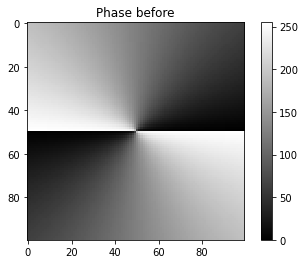

In [360]:
obtain_trial_phase()